In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [18]:
df = pd.read_csv('gold_2021.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["Volume", "Open", "Oil Close", "CAD Close", "Low", "High"])
df

,Gold Close,TSX Close,Bar Close
Date,,,
2010-01-04,1117.699951,11866.900391,35.995537
2010-01-05,1118.099976,11888.099609,36.337681
2010-01-06,1135.900024,11944.500000,36.936466
2010-01-07,1133.099976,11887.500000,36.474537
2010-01-08,1138.199951,11953.799805,36.560101
...,...,...,...
2021-01-14,1850.300049,17958.099609,29.910000
2021-01-15,1829.300049,17909.000000,29.459999
2021-01-19,1839.500000,17957.400391,29.809999


In [19]:
df_input = df
df_output = df[["Bar Close"]]

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.3, random_state=42, shuffle= False)

In [21]:
x_train.shape

(1887, 3)

In [22]:
x_test.shape

(810, 3)

In [23]:
x_test

,Gold Close,TSX Close,Bar Close
Date,,,
2017-09-21,1290.599976,15454.900391,19.391613
2017-09-22,1293.300049,15454.200195,19.430107
2017-09-25,1306.800049,15516.200195,19.766932
2017-09-26,1297.000000,15474.099609,19.516718
2017-09-27,1283.400024,15609.700195,19.516718
...,...,...,...
2021-01-14,1850.300049,17958.099609,29.910000
2021-01-15,1829.300049,17909.000000,29.459999
2021-01-19,1839.500000,17957.400391,29.809999


In [24]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)

y_train_scaler.fit(y_train)
y_test_scaler.fit(y_test)

x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(x_test)

y_train = y_train_scaler.transform(y_train)
y_test = y_test_scaler.transform(y_test)


In [25]:
length = 1
batch = 1
features = 3

train_generator = TimeseriesGenerator(x_train, y_train, length=length, sampling_rate=1, batch_size=batch)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, sampling_rate=1, batch_size=batch)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [27]:
model = Sequential()
units = 64
drop = 0.2

#1st layer
model.add(LSTM(units=units, return_sequences=True, input_shape=(length, features)))
model.add(Dropout(drop))

#2nd layer
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(drop))

#3rd layer
model.add(LSTM(units=units))
model.add(Dropout(drop))

# Output layer
model.add(Dense(1))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 64)             17408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [29]:
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss < self.threshold:
            self.model.stop_training = True

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

earlystop = ThresholdCallback(threshold=0.0006277)

model.compile(optimizer="adam", loss="mean_squared_error")

model.fit_generator(train_generator, epochs = 250, validation_data=test_generator,
                         shuffle=False, callbacks=[earlystop])

Epoch 1/250
1886/1886 [==============================] - 17s 7ms/step - loss: 0.0025 - val_loss: 0.0202
Epoch 2/250
1886/1886 [==============================] - 13s 7ms/step - loss: 0.0020 - val_loss: 0.0224
Epoch 3/250
1457/1886 [======================>.......] - ETA: 2s - loss: 0.0020

KeyboardInterrupt: 

In [ ]:
model.evaluate_generator(test_generator, verbose=0)

In [17]:
predictions = model.predict_generator(test_generator)

C:\Users\1ames\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [18]:
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test[1:].reshape(-1,1))

In [19]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks
bar_csv_data = stocks.to_csv('Barrick_day.csv', index = True) 

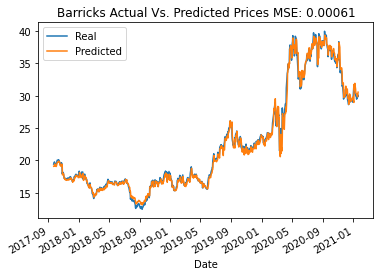

In [20]:
stocks.plot(title=f"Barricks Actual Vs. Predicted Prices MSE: 0.00061")
plt.savefig('BarrickDay.png')

In [21]:
stocks["diff"] = stocks["Real"] - stocks["Predicted"]
stocks["diff"].mean()

0.06407172718213129

In [22]:
min(fit.history["val_loss"])

0.0006052161916159093

In [23]:
stocks["pct real"] = stocks["Real"].pct_change() 
stocks["pct pred"] = stocks["Predicted"].pct_change()
stocks["pos real"] = np.where(stocks['pct real'] > 0, 1, 0)
stocks["pos pred"] = np.where(stocks['pct pred'] > 0, 1, 0)
stocks["test"] = abs(stocks["pos pred"] - stocks["pos real"])
stocks['test'].sum()

421

In [24]:
prediction = stocks["Predicted"].loc["2021-01-20"]
prediction

30.228447

In [25]:
stocks

,Real,Predicted,diff,pct real,pct pred,pos real,pos pred,test
Date,,,,,,,,
2017-09-22,19.430107,19.092068,0.338039,NaN,NaN,0,0,0
2017-09-25,19.766932,19.126595,0.640337,0.017335,0.001808,1,1,0
2017-09-26,19.516718,19.455784,0.060934,-0.012658,0.017211,0,1,1
2017-09-27,19.516718,19.211124,0.305593,0.000000,-0.012575,0,0,0
2017-09-28,19.391613,19.251865,0.139748,-0.006410,0.002121,0,1,1
...,...,...,...,...,...,...,...,...
2021-01-14,29.910000,30.346361,-0.436361,-0.001336,-0.001543,0,0,0
2021-01-15,29.459999,30.315649,-0.855650,-0.015045,-0.001012,0,0,0
2021-01-19,29.809999,29.827175,-0.017176,0.011881,-0.016113,1,0,1
